In [122]:
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier
from sklearn import datasets

from scipy import optimize

import numpy as np

import matplotlib.pyplot as plt


def calculate_ridge(X_param, y_param, k):
    return np.linalg.pinv((X_param.T @ X_param) + (k * np.identity(len(X_param.T)))) @ (X_param.T @ y_param)


def normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))


def calculate_values(mX, theta):
    return np.sum(np.matmul(mX, theta))


noise = 16
samples = 2423
seed = 244823
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

array([[ 1.87565992, -0.52333906],
       [-0.79002326, -1.0257257 ],
       [-1.40374054, -0.83591701],
       ...,
       [-1.17246351, -1.17520661],
       [ 2.3756229 , -0.23595682],
       [-1.91841241, -1.5641893 ]])

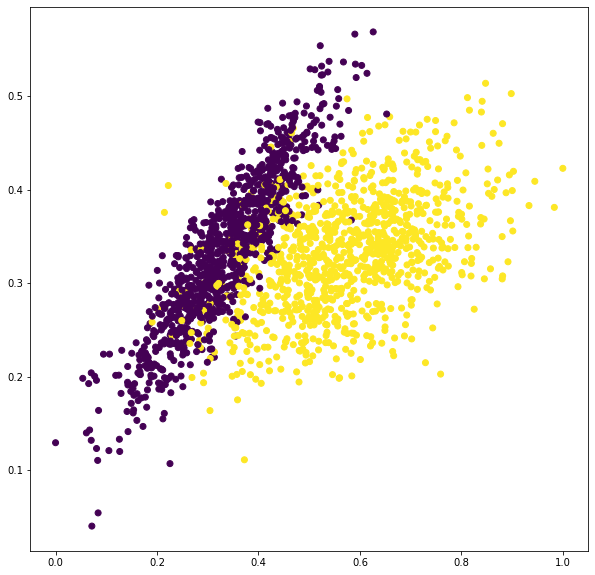

In [123]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

X_train = normalize(X_train)
y_train = normalize(y_train)
X_test = normalize(X_test)
y_test = normalize(y_test)

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
X

[[ 5.0354256  -4.98596799]]
[ 2.68945725 -2.19423779]


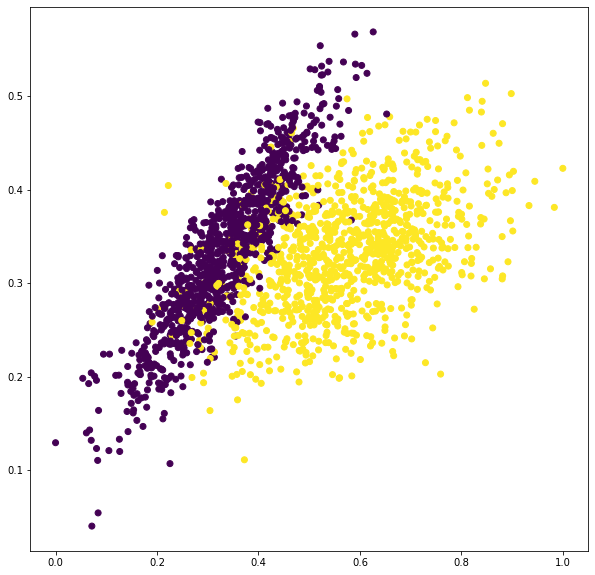

In [124]:
model_ridge = RidgeClassifier(copy_X=True, tol=1)
model_ridge.fit(X_train, y_train)

print(model_ridge.coef_)

my_ridge = calculate_ridge(X_train, y_train, 0.000001)

predict = model_ridge.predict(X_test)

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

print(my_ridge)

